In [1]:
import pickle as pkl
import sys
sys.path.append('/Users/cosinga/code/hcolor/fig_md_analysis/')
sys.path.append('/Users/cosinga/code/figrid/')
import pk_plot_library as pplib
import numpy as np
import matplotlib.pyplot as plt

DRAFTPATH = '/Users/cosinga/overleaf/hicolor_draft_two/figures/'
SAVEPATH = '/Users/cosinga/code/hcolor/fig_md_analysis/rvb/'
WEBPATH = '/Users/cosinga/code/calvinosinga.github.io/hicolor/sup_analysis/'
pplib.imports()

def fill_mean(ax, data, kwargs):
    x = data[0]
    y = np.mean(np.array([data[1], data[2]]), axis = 0)
    kwargs['alpha'] = 1
    ax.plot(x, y, **kwargs)
    return
def renorm(dc):
    data = dc.getData()
    data[1] = data[0]**2 * data[1]
    dc.setData(data)
    return dc
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15')
def kaiser(z, bias):
    D = cosmo.growthFactor(z, derivative = 0)
    dDdz = cosmo.growthFactor(z, derivative = 1)
    f = -dDdz * (z + 1) / D
    beta = f / bias
    return (1 + 2/3 * beta + 1/5 * beta**2)
def Plin(k, z):
    return cosmo.matterPowerSpectrum(k, z)


ds = pkl.load(open('/Users/cosinga/code/hcolor/fig_md_analysis/12-29_pkdatasort.pkl', 'rb'))


In [2]:
def get_pk(fn, **others):
    def sub_get(ip, subtype):
        ip['subtype'] = subtype
        dclist = ds.getMatching(ip)
        if len(dclist) > 1:
            print("too many DCs found")
            for dc in dclist:
                print(dc.attrs)
        print(dclist[0].get('empty_cells'))
        return dclist[0].getData()
    ip = {
        'path':'vel',
        'fieldname':fn,
        'space':'real',
        'grid_resolution':200
    }
    ip.update(others)
    dd = sub_get(ip, 'delta_delta')
    tt = sub_get(ip, 'theta_theta')
    td = sub_get(ip, 'theta_delta')
    ip['space'] = 'redshift'
    dd_s = sub_get(ip, 'delta_delta')
    return dd, td, tt, dd_s


In [3]:
pdd, ptd, ptt, prss = get_pk('ptl', ptl_species = 'ptl')

no key found
0
0
no key found


# Confirming Expression for Redshift-Space Monopole

<a href="https://wwwmpa.mpa-garching.mpg.de/~komatsu/lecturenotes/Shun_Saito_on_RSD.pdf">Link to Reference</a>

Equation 21: Expanding the anisotropic power spectrum with Legendre Polynomials

$P^s(k, \mu) = \sum_{\ell} P_{\ell}^s(k) \mathcal{L}_{\ell}(\mu)$

I believe that $P_{\ell}$ is in redshift space, although it is not explicitly notated in the reference.

Legendre Polynomials are orthogonal, giving

$\int_{-1}^{1} \mathcal{L}_{\ell}(\mu) \mathcal{L}_{\ell'}(\mu) \, d\mu = \frac{2}{2\ell + 1} \delta_{\ell\ell'}$

$\int_{-1}^{1} P^s(k, \mu) \mathcal{L}_{\ell'}(\mu) \, d\mu = \sum_{\ell} P_{\ell}(k) \int_{-1}^{1} \mathcal{L}_{\ell}(\mu) \mathcal{L}_{\ell'}(\mu) \, d\mu$

$\int_{-1}^{1} P^s(k, \mu) \mathcal{L}_{\ell'}(\mu) \, d\mu = P_{\ell'}(k)$

We then arrive at the following expression, which tells us how to get from the anisotropic power spectrum to P(k):

$P_{\ell'}^s(k) = \frac{2\ell' + 1}{2} \int_{-1}^{1} P^s(k, \mu) \mathcal{L}_{\ell'}(\mu) \, d\mu$

Only $l = 0, 2, 4$ have non-vanishing terms in the Kaiser formula. Here are are these terms: $\mathcal{L}_0 (x)= 1$, $\mathcal{L}_2 (x)= 1/2 (3x^2-1)$, $\mathcal{L}_4 (x) = 1/8(35x^4 - 30x^2 + 3)$. For my purposes, I have only used the monopole.

$P_0^s (k) = 1/2 \int_{-1}^1 d\mu P^s (k, \mu)$

Equation 30: expressing the kaiser effect, including the linear and non-linear terms.

$P^s_{\rm{L}} (k, \mu) = (1 + f \mu^2)^2 P^r_{\delta \delta}(k)$

$P^s_{\rm{NL}} (k, \mu) = P^r_{\delta \delta}(k) + 2f\mu^2 P_{\delta \theta} (k) + f^2 \mu^4 P_{\theta \theta} (k)$

Combining the expression that gives $P(k)$ from $P(k, \mu)$ and the above equation, we can get the general equation for redshift-space distortions for the monopole.

$P_0^s (k) = P^r_{\delta \delta}(k) + 2/3 f P_{\delta \theta} (k) + 1/5 f^2 P_{\theta \theta} (k)$

In other words, the anisotropic power spectrum has the same expression as the monopole of the isotropic power spectrum.

Check out papers describing velocity bias assumptions...



In [4]:
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15')
def growth_rate(z):
    D = cosmo.growthFactor(z, derivative = 0)
    dDdz = cosmo.growthFactor(z, derivative = 1)
    f = -dDdz * (z + 1) / D
    return f

Text(0.5, 0, 'k (cMpc/h)')

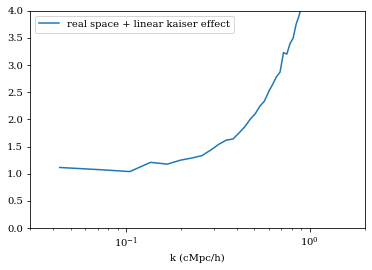

In [5]:
f = growth_rate(1)
pred = (1 + 2/3 * f + f**2 / 5) * pdd[1]
plt.plot(pdd[0], pred / prss[1], label = 'real space + linear kaiser effect')
plt.xscale('log')
plt.legend()
plt.xlim(0.03, 2)
plt.ylim(0, 4)
plt.xlabel('k (cMpc/h)')

Text(0.5, 1.0, '200$^3$ Grid, TNG 300, z = 1')

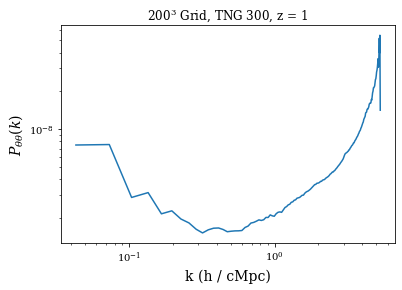

In [6]:
plt.plot(ptt[0], ptt[1])
plt.ylabel(r"$P_{\theta \theta} (k)$", fontsize = 14)
plt.xlabel(r"k (h / cMpc)", fontsize = 14)
plt.loglog()
plt.title("200$^3$ Grid, TNG 300, z = 1")

Text(0.5, 1.0, '200$^3$ Grid, TNG 300, z = 1')

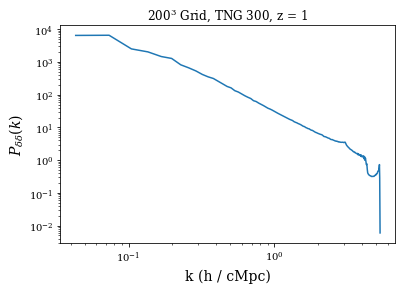

In [7]:
plt.plot(prss[0], prss[1])
plt.ylabel(r"$P_{\delta \delta} (k)$", fontsize = 14)
plt.xlabel(r"k (h / cMpc)", fontsize = 14)
plt.loglog()
plt.title("200$^3$ Grid, TNG 300, z = 1")